### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import geopy

### Imports Dataset

In [2]:
airbnbData = pd.read_csv('./Data/Airbnb_Open_Data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Analyzing Data

### Checking dataset essentials

In [3]:
print("Shape: ", airbnbData.shape, "\n")

print("Columns: ", airbnbData.columns, "\n\n")

# Dropping columns that won't be usuful to model or has data leakage
droppingColumns = [
    'id', 'NAME', 'host id', 'host name', 'last review',
    'calculated host listings count', 'house_rules', 'license', 'availability 365',
    'country', 'country code']

airbnbData.drop(droppingColumns, axis =1 , inplace=True)

print("Null count before dropping:\n ",airbnbData.isnull().sum(), "\n\n")

# Drops all rows with a null value since the dataset is large
airbnbData = airbnbData.loc[airbnbData.isnull().sum(axis=1) == 0,:]
print("Shape after dropping:\n ", airbnbData.shape)
print("Null count after droping:\n ", airbnbData.isnull().sum())

airbnbData

Shape:  (102599, 26) 

Columns:  Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object') 


Null count before dropping:
  host_identity_verified      289
neighbourhood group          29
neighbourhood                16
lat                           8
long                          8
instant_bookable            105
cancellation_policy          76
room type                     0
Construction year           214
price                       247
service fee                 273
minimum nights              409
number of reviews           183
reviews per month     

,host_identity_verified,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,$966,$193,10.0,9.0,0.21,4.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,0.38,4.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,4.64,4.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,0.10,3.0
5,verified,Manhattan,Murray Hill,40.74767,-73.97500,True,flexible,Entire home/apt,2013.0,$577,$115,3.0,74.0,0.59,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102588,unconfirmed,Manhattan,Flatiron District,40.74068,-73.98999,True,flexible,Entire home/apt,2016.0,$618,$124,1.0,177.0,3.78,4.0
102591,verified,Manhattan,Upper West Side,40.77408,-73.98181,False,strict,Entire home/apt,2005.0,"$1,139",$228,5.0,17.0,0.35,5.0
102593,verified,Manhattan,East Village,40.72826,-73.98422,True,strict,Private room,2017.0,"$1,099",$220,1.0,8.0,0.16,4.0
102595,unconfirmed,Manhattan,Morningside Heights,40.80460,-73.96545,True,moderate,Private room,2016.0,$837,$167,1.0,1.0,0.02,2.0


### Removing all none well rated posts

In [4]:
# Must have more than 4 star rating
# Must have more than 1 review per month
# Must have more than 20 reviews

print("Reviews per month mean: " ,airbnbData['reviews per month'].mean())
print("Number of reviews mean: " ,airbnbData['number of reviews'].mean())
print("Reviews rate mean: " , airbnbData['review rate number'].mean())

print("\nOriginal Shape: " ,airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['review rate number'] >= 4,:]

print("After a low score remvoving: " ,airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['number of reviews'] >= 10,:]

print("After removing number of reviews: " , airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['reviews per month'] >= 0.5,:]

print("After removing low monthly review rate dropping: " , airbnbData.shape)


#Reset the index

airbnbData.reset_index(inplace=True, drop=True)



Reviews per month mean:  1.3747339425832923
Number of reviews mean:  32.26613964196777
Reviews rate mean:  3.2802236526805433

Original Shape:  (85132, 15)
After a low score remvoving:  (38827, 15)
After removing number of reviews:  (20481, 15)
After removing low monthly review rate dropping:  (17700, 15)


### Converts string dollars to floats

In [5]:
dollarsColumns = ['price', 'service fee']

# Uses Regex to remove all none numeric characters
# Then converts the column to numeric values
for dolCol in dollarsColumns:  
    airbnbData[dolCol] = airbnbData[dolCol].apply(lambda x: re.sub(r'\D', '',x))
    airbnbData[dolCol] = pd.to_numeric(airbnbData[dolCol])

airbnbData[dollarsColumns]

,price,service fee
0,368,74
1,291,58
2,714,143
3,580,116
4,439,88
...,...,...
17695,605,121
17696,985,197
17697,294,59
17698,77,15


## Visualizing Data

In [6]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'gray'})

### Visualizing Price

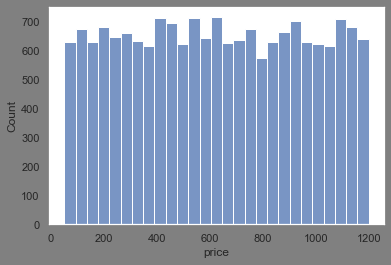

In [7]:
sns.histplot(data = airbnbData, x='price')

plt.show()

### Visualizing Room Type

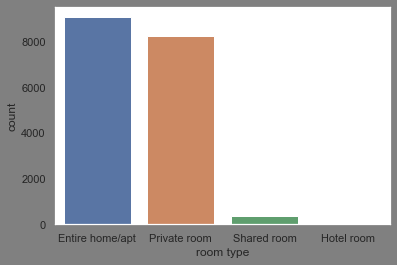

In [8]:
sns.countplot(data = airbnbData, x='room type')

plt.show()

### Visualizing Instant Bookable

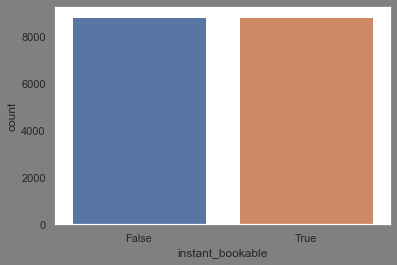

In [9]:
sns.countplot(data = airbnbData, x='instant_bookable')

plt.show()

### Visualizing Cancelation Policy

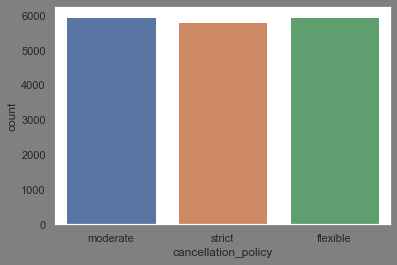

In [10]:
sns.countplot(data = airbnbData, x='cancellation_policy')

plt.show()

## Getting the zipcode of locations

In [ ]:
geolocator = geopy.Nominatim(user_agent="AirbnbReactWebsite")

postalInfoDf = pd.read_csv('./Data/PostalInfo.csv')


for i,x in airbnbData.iterrows():
    
    if i < len(postalInfoDf.index):
        continue
    
    location = geolocator.reverse((x.lat, x.long))
    locationRaw = location.raw['display_name'].split(', ')
    
    postalCode =  [locationRaw[-2], locationRaw[-1]]
    
    print(i, "/" , airbnbData.shape[0] ,': ', postalCode)
    
    postalInfoDf.loc[i] = postalCode
    
    if i %100 == 0:
        postalInfoDf.to_csv('./Data/PostalInfo.csv' ,index=False)

print('Finished getting all postal Info')
        
airbnbData



6001 / 17700 :  ['10458', 'United States']
6002 / 17700 :  ['10009', 'United States']
6003 / 17700 :  ['11211', 'United States']
6004 / 17700 :  ['11215', 'United States']
6005 / 17700 :  ['11217', 'United States']
6006 / 17700 :  ['11223', 'United States']
6007 / 17700 :  ['11206', 'United States']
6008 / 17700 :  ['11237', 'United States']
6009 / 17700 :  ['10019', 'United States']
6010 / 17700 :  ['11235', 'United States']
6011 / 17700 :  ['10024', 'United States']
6012 / 17700 :  ['10454', 'United States']
6013 / 17700 :  ['10028', 'United States']
6014 / 17700 :  ['10019', 'United States']
6015 / 17700 :  ['10023', 'United States']
6016 / 17700 :  ['10040', 'United States']
6017 / 17700 :  ['11237', 'United States']
6018 / 17700 :  ['11236', 'United States']
6019 / 17700 :  ['11213', 'United States']
6020 / 17700 :  ['11211', 'United States']
6021 / 17700 :  ['11211', 'United States']
6022 / 17700 :  ['11231', 'United States']
6023 / 17700 :  ['10467', 'United States']
6024 / 1770

6192 / 17700 :  ['10275', 'United States']
6193 / 17700 :  ['11221', 'United States']
6194 / 17700 :  ['10451', 'United States']
6195 / 17700 :  ['11434', 'United States']
6196 / 17700 :  ['11216', 'United States']
6197 / 17700 :  ['11216', 'United States']
6198 / 17700 :  ['11221', 'United States']
6199 / 17700 :  ['10026', 'United States']
6200 / 17700 :  ['10025', 'United States']
6201 / 17700 :  ['10016', 'United States']
6202 / 17700 :  ['11205', 'United States']
6203 / 17700 :  ['11238', 'United States']
6204 / 17700 :  ['10009', 'United States']
6205 / 17700 :  ['10031', 'United States']
6206 / 17700 :  ['11354', 'United States']
6207 / 17700 :  ['11221', 'United States']
6208 / 17700 :  ['11225', 'United States']
6209 / 17700 :  ['11369', 'United States']
6210 / 17700 :  ['10027', 'United States']
6211 / 17700 :  ['10009', 'United States']
6212 / 17700 :  ['11233', 'United States']
6213 / 17700 :  ['11211', 'United States']
6214 / 17700 :  ['10026', 'United States']
6215 / 1770

6383 / 17700 :  ['10026', 'United States']
6384 / 17700 :  ['11212', 'United States']
6385 / 17700 :  ['10199', 'United States']
6386 / 17700 :  ['10199', 'United States']
6387 / 17700 :  ['10018', 'United States']
6388 / 17700 :  ['10018', 'United States']
6389 / 17700 :  ['10018', 'United States']
6390 / 17700 :  ['10018', 'United States']
6391 / 17700 :  ['10018', 'United States']
6392 / 17700 :  ['11422', 'United States']
6393 / 17700 :  ['11217', 'United States']
6394 / 17700 :  ['10035', 'United States']
6395 / 17700 :  ['11249', 'United States']
6396 / 17700 :  ['10002', 'United States']
6397 / 17700 :  ['10033', 'United States']
6398 / 17700 :  ['10026', 'United States']
6399 / 17700 :  ['11226', 'United States']
6400 / 17700 :  ['10030', 'United States']
6401 / 17700 :  ['11225', 'United States']
6402 / 17700 :  ['11203', 'United States']
6403 / 17700 :  ['11103', 'United States']
6404 / 17700 :  ['10128', 'United States']
6405 / 17700 :  ['11216', 'United States']
6406 / 1770

6574 / 17700 :  ['11226', 'United States']
6575 / 17700 :  ['10037', 'United States']
6576 / 17700 :  ['10002', 'United States']
6577 / 17700 :  ['11221', 'United States']
6578 / 17700 :  ['10024', 'United States']
6579 / 17700 :  ['11211', 'United States']
6580 / 17700 :  ['11103', 'United States']
6581 / 17700 :  ['11102', 'United States']
6582 / 17700 :  ['11211', 'United States']
6583 / 17700 :  ['10451', 'United States']
6584 / 17700 :  ['11434', 'United States']
6585 / 17700 :  ['10009', 'United States']
6586 / 17700 :  ['10128', 'United States']
6587 / 17700 :  ['11233', 'United States']
6588 / 17700 :  ['11413', 'United States']
6589 / 17700 :  ['11106', 'United States']
6590 / 17700 :  ['10003', 'United States']
6591 / 17700 :  ['10025', 'United States']
6592 / 17700 :  ['10019', 'United States']
6593 / 17700 :  ['10451', 'United States']
6594 / 17700 :  ['10026', 'United States']
6595 / 17700 :  ['10027', 'United States']
6596 / 17700 :  ['11373', 'United States']
6597 / 1770

6765 / 17700 :  ['10026', 'United States']
6766 / 17700 :  ['11208', 'United States']
6767 / 17700 :  ['11233', 'United States']
6768 / 17700 :  ['10002', 'United States']
6769 / 17700 :  ['11101', 'United States']
6770 / 17700 :  ['11211', 'United States']
6771 / 17700 :  ['11216', 'United States']
6772 / 17700 :  ['10021', 'United States']
6773 / 17700 :  ['10041', 'United States']
6774 / 17700 :  ['10035', 'United States']
6775 / 17700 :  ['11213', 'United States']
6776 / 17700 :  ['10065', 'United States']
6777 / 17700 :  ['11207', 'United States']
6778 / 17700 :  ['10023', 'United States']
6779 / 17700 :  ['10304', 'United States']
6780 / 17700 :  ['11231', 'United States']
6781 / 17700 :  ['11103', 'United States']
6782 / 17700 :  ['11207', 'United States']
6783 / 17700 :  ['11103', 'United States']
6784 / 17700 :  ['11103', 'United States']
6785 / 17700 :  ['11434', 'United States']
6786 / 17700 :  ['10016', 'United States']
6787 / 17700 :  ['11372', 'United States']
6788 / 1770

6956 / 17700 :  ['10019', 'United States']
6957 / 17700 :  ['10028', 'United States']
6958 / 17700 :  ['11221', 'United States']
6959 / 17700 :  ['11385', 'United States']
6960 / 17700 :  ['10036', 'United States']
6961 / 17700 :  ['11221', 'United States']
6962 / 17700 :  ['11373', 'United States']
6963 / 17700 :  ['10002', 'United States']
6964 / 17700 :  ['10002', 'United States']
6965 / 17700 :  ['10019', 'United States']
6966 / 17700 :  ['10002', 'United States']
6967 / 17700 :  ['11233', 'United States']
6968 / 17700 :  ['10019', 'United States']
6969 / 17700 :  ['11204', 'United States']
6970 / 17700 :  ['11435', 'United States']
6971 / 17700 :  ['11373', 'United States']
6972 / 17700 :  ['10033', 'United States']
6973 / 17700 :  ['10016', 'United States']
6974 / 17700 :  ['11373', 'United States']
6975 / 17700 :  ['10009', 'United States']
6976 / 17700 :  ['10019', 'United States']
6977 / 17700 :  ['11373', 'United States']
6978 / 17700 :  ['10036', 'United States']
6979 / 1770

7147 / 17700 :  ['10027', 'United States']
7148 / 17700 :  ['10002', 'United States']
7149 / 17700 :  ['11106', 'United States']
7150 / 17700 :  ['11221', 'United States']
7151 / 17700 :  ['11211', 'United States']
7152 / 17700 :  ['10032', 'United States']
7153 / 17700 :  ['11369', 'United States']
7154 / 17700 :  ['11221', 'United States']
7155 / 17700 :  ['11226', 'United States']
7156 / 17700 :  ['10001', 'United States']
7157 / 17700 :  ['11101', 'United States']
7158 / 17700 :  ['10026', 'United States']
7159 / 17700 :  ['11355', 'United States']
7160 / 17700 :  ['10031', 'United States']
7161 / 17700 :  ['11221', 'United States']
7162 / 17700 :  ['10024', 'United States']
7163 / 17700 :  ['10035', 'United States']
7164 / 17700 :  ['11226', 'United States']
7165 / 17700 :  ['11217', 'United States']
7166 / 17700 :  ['11217', 'United States']
7167 / 17700 :  ['11211', 'United States']
7168 / 17700 :  ['11373', 'United States']
7169 / 17700 :  ['10024', 'United States']
7170 / 1770

7338 / 17700 :  ['10037', 'United States']
7339 / 17700 :  ['11218', 'United States']
7340 / 17700 :  ['11412', 'United States']
7341 / 17700 :  ['10031', 'United States']
7342 / 17700 :  ['11206', 'United States']
7343 / 17700 :  ['10029', 'United States']
7344 / 17700 :  ['10003', 'United States']
7345 / 17700 :  ['11209', 'United States']
7346 / 17700 :  ['11216', 'United States']
7347 / 17700 :  ['11435', 'United States']
7348 / 17700 :  ['10010', 'United States']
7349 / 17700 :  ['10025', 'United States']
7350 / 17700 :  ['11211', 'United States']
7351 / 17700 :  ['11231', 'United States']
7352 / 17700 :  ['11434', 'United States']
7353 / 17700 :  ['11221', 'United States']
7354 / 17700 :  ['11429', 'United States']
7355 / 17700 :  ['11691', 'United States']
7356 / 17700 :  ['11220', 'United States']
7357 / 17700 :  ['11216', 'United States']
7358 / 17700 :  ['11221', 'United States']
7359 / 17700 :  ['10065', 'United States']
7360 / 17700 :  ['10013', 'United States']
7361 / 1770

7529 / 17700 :  ['10005', 'United States']
7530 / 17700 :  ['10457', 'United States']
7531 / 17700 :  ['11209', 'United States']
7532 / 17700 :  ['10009', 'United States']
7533 / 17700 :  ['10461', 'United States']
7534 / 17700 :  ['11375', 'United States']
7535 / 17700 :  ['11237', 'United States']
7536 / 17700 :  ['11232', 'United States']
7537 / 17700 :  ['10036', 'United States']
7538 / 17700 :  ['11377', 'United States']
7539 / 17700 :  ['11249', 'United States']
7540 / 17700 :  ['11429', 'United States']
7541 / 17700 :  ['10009', 'United States']
7542 / 17700 :  ['10035', 'United States']
7543 / 17700 :  ['11369', 'United States']
7544 / 17700 :  ['10018', 'United States']
7545 / 17700 :  ['11233', 'United States']
7546 / 17700 :  ['11225', 'United States']
7547 / 17700 :  ['10009', 'United States']
7548 / 17700 :  ['11236', 'United States']
7549 / 17700 :  ['11207', 'United States']
7550 / 17700 :  ['10469', 'United States']
7551 / 17700 :  ['11206', 'United States']
7552 / 1770